In [1]:
import json
from tqdm import tqdm
import random
from pprint import pprint
import os
import collections
from typing import List, Dict, Tuple
import logging
from fastai import *
from fastai.vision import *
from sklearn.metrics import f1_score
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')


path = '../data/proteins_imgs/U_RISC_OPEN_DATA_SIMPLE'
path = Path(path)
path.ls()

[PosixPath('../data/proteins_imgs/U_RISC_OPEN_DATA_SIMPLE/labels'),
 PosixPath('../data/proteins_imgs/U_RISC_OPEN_DATA_SIMPLE/train'),
 PosixPath('../data/proteins_imgs/U_RISC_OPEN_DATA_SIMPLE/val'),
 PosixPath('../data/proteins_imgs/U_RISC_OPEN_DATA_SIMPLE/models')]

In [2]:
# defaults.device = torch.device('cpu')

In [2]:
fnames = get_image_files(path / 'train')
fnames[:3]

[PosixPath('../data/proteins_imgs/U_RISC_OPEN_DATA_SIMPLE/train/0001_1.png'),
 PosixPath('../data/proteins_imgs/U_RISC_OPEN_DATA_SIMPLE/train/0007_1.png'),
 PosixPath('../data/proteins_imgs/U_RISC_OPEN_DATA_SIMPLE/train/0009_1.png')]

In [3]:
src = ImageImageList.from_folder(path, exclude=['labels', 'val'])
src = src.split_by_rand_pct(0.3)
src = src.label_from_func(lambda x: path / 'labels'/ 'train' / f'{x.stem}.tiff' if int(str(x.stem).split('_')[0])>31 else path / 'labels'/ 'train' / f'{x.stem}_m.tiff')

data = src.databunch(bs = 2, device = defaults.device)
data = data.normalize(imagenet_stats)

In [4]:
data

ImageDataBunch;

Train: LabelList (21 items)
x: ImageImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: ImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
Path: ../data/proteins_imgs/U_RISC_OPEN_DATA_SIMPLE;

Valid: LabelList (9 items)
x: ImageImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: ImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
Path: ../data/proteins_imgs/U_RISC_OPEN_DATA_SIMPLE;

Test: None

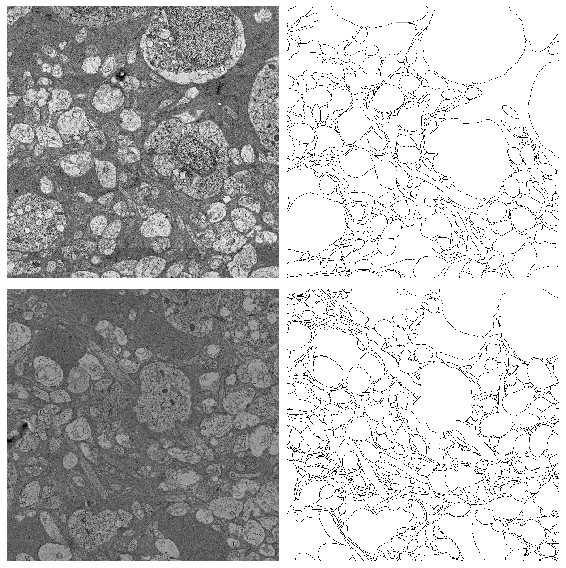

In [5]:
data.show_batch()

In [6]:
(data.train_ds.y[0])._px.shape

torch.Size([3, 1024, 1024])

In [7]:
(data.train_ds.x[0])._px.shape

torch.Size([3, 1024, 1024])

In [8]:
(data.train_ds.y[0])._px.min()

tensor(0.)

In [9]:
(data.train_ds.y[0])._px.max()

tensor(1.)

In [10]:
import torch
# class Mymodel(torch.nn.Module):
#     def __init__(self, base):
#         super(Mymodel, self).__init__()
#         print(base)
# #         del base.fc
# #         del base.avgpool

#         self.base = base
#         self.decoder = torch.nn.ModuleList(
#             [conv2d_trans(512, 1024), torch.nn.Sigmoid()]
#         )
#     def forward(self, x):
#         print(x.shape)
#         x = self.base(x)
#         print(x.shape)
#         for layer in self.decoder:
#             x = layer(x)
#             print(x.shape)
#         return x
    
def simple_cnn(actns:Collection[int], kernel_szs:Collection[int]=None,
               strides:Collection[int]=None, bn=False) -> nn.Sequential:
    "CNN with `conv_layer` defined by `actns`, `kernel_szs` and `strides`, plus batchnorm if `bn`."
    nl = len(actns)-1
    kernel_szs = ifnone(kernel_szs, [3]*nl)
    strides    = ifnone(strides   , [1]*nl)
    layers = [conv_layer(actns[i], actns[i+1], kernel_szs[i], stride=strides[i], padding = 1,
              norm_type=(NormType.Batch if bn and i<(len(strides)-1) else None)) for i in range_of(strides)]
    layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)

In [11]:
model = simple_cnn([3, 64, 64, 3])

In [11]:
# learn = Learner(data, Mymodel(create_body(models.resnet18, True, None)), loss_func = F.l1_loss)

In [5]:
def my_metric(x, y):
    x = x.view(-1)
    y = y.view(-1)
    assert x.shape == y.shape
    x = x.round()
    y = y.long()
    return torch.tensor(f1_score(y, x)) # 顺序别搞反

In [11]:
learn = Learner(data,model, loss_func = F.binary_cross_entropy, metrics = my_metric )

In [12]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (3): Sigmoid()
)

In [13]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 1024, 1024]     1,792      True      
______________________________________________________________________
ReLU                 [64, 1024, 1024]     0          False     
______________________________________________________________________
Conv2d               [64, 1024, 1024]     36,928     True      
______________________________________________________________________
ReLU                 [64, 1024, 1024]     0          False     
______________________________________________________________________
Conv2d               [3, 1024, 1024]      1,731      True      
______________________________________________________________________
ReLU                 [3, 1024, 1024]      0          False     
______________________________________________________________________
Sigmoid              [3, 1024, 1024]      0          False     
___________________________________________________

In [14]:
learn.fit_one_cycle(5, max_lr = 1e-2)

epoch,train_loss,valid_loss,my_metric,time
0,0.451104,0.222449,0.973411,00:48
1,0.323331,0.237007,0.973411,00:20
2,0.277458,0.192822,0.973411,00:23
3,0.249740,0.171674,0.973411,00:29
4,0.229308,0.174897,0.973410,00:36


In [15]:
learn.save('./protein')

In [16]:
learn.load('./protein')

Learner(data=ImageDataBunch;

Train: LabelList (21 items)
x: ImageImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: ImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
Path: ../data/proteins_imgs/U_RISC_OPEN_DATA_SIMPLE;

Valid: LabelList (9 items)
x: ImageImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: ImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
Path: ../data/proteins_imgs/U_RISC_OPEN_DATA_SIMPLE;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (2): Sequential(
    (

In [ ]:
def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
    "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
    title = 'Input / Prediction / Target'
    axs = subplots(len(xs), 3, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
    for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
        x.show(ax=axs[i,0], **kwargs)
        y.show(ax=axs[i,2], **kwargs)
        if z._px.min() < 0 or z._px.max()>1：
            z._px = F.sigmoid(z._px)
        f = Image(torch.round(z._px))
        f.show(ax=axs[i,1], **kwargs)
ImageImageList.show_xyzs = show_xyzs

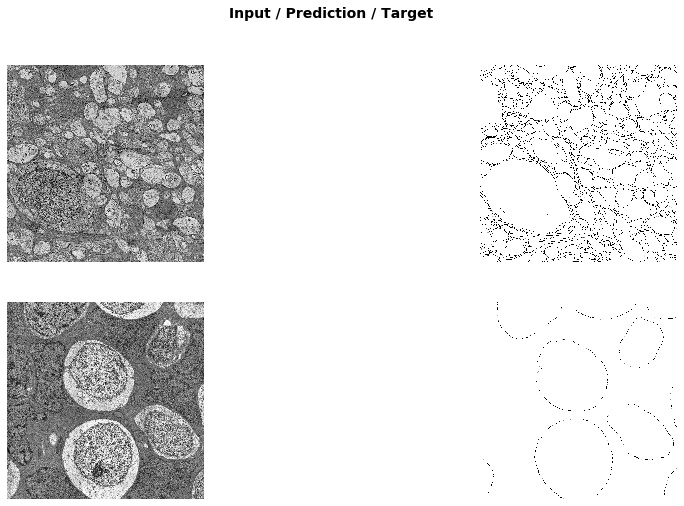

In [18]:
learn.show_results()

为什么f1_score 那么高，结果并不好？  
原因在于：  
像素0才是我们关心的。。代表黑色

In [19]:
def modified_metric(x, y):
    x = x.view(-1)
    y = y.view(-1)
    assert x.shape == y.shape
    x = x.round()
    y = y.long()
    assert x.shape == y.shape
    return torch.tensor(f1_score(y, x, pos_label = 0)) # 修改pos的标签是啥

In [20]:
learn.metrics

[<function __main__.my_metric(x, y)>]

In [21]:
learn.metrics = [modified_metric]

In [22]:
learn.fit_one_cycle(3, max_lr=1e-2)

epoch,train_loss,valid_loss,modified_metric,time
0,0.174832,0.173048,0.000003,00:22
1,0.179155,0.177111,0.001309,00:22
2,0.176308,0.162525,0.000009,00:20


/home/liangjiaxi/anaconda3/envs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


修正了之后才知道结果有多烂

如何才能进一步提升结果呢？  
考虑使用预训练模型  
然而预训练模型可能会存在输入头不匹配的情况

In [23]:
def create_cnn_model(base_arch:Callable, nc:int, cut:Union[int,Callable]=None, pretrained:bool=True,
                     lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, custom_head:Optional[nn.Module]=None,
                     bn_final:bool=False, concat_pool:bool=True):
    "Create custom convnet architecture"
    body = create_body(base_arch, pretrained, cut) # body 是一个 sequential
#     if custom_head is None:
#         nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1) #返回１０２４
#         head = create_head(nf, nc, lin_ftrs, ps=ps, concat_pool=concat_pool, bn_final=bn_final)
#     else: head = custom_head
    return nn.Sequential(body) # 原来是这样进行拼接~！

In [24]:
t = create_cnn_model(models.resnet18, 2)

In [25]:
t

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [26]:
torch.randn((1, 3,1024,1024)).shape

torch.Size([1, 3, 1024, 1024])

In [27]:
t(torch.randn((1, 3,1024,1024))).shape

torch.Size([1, 512, 32, 32])

In [28]:
lst = [
    conv_layer(512, 128,  4, stride = 2,padding = 1, transpose=True),
    conv_layer(128, 64,  4, stride = 2,padding = 1, transpose=True),
    conv_layer(64, 32,  4, stride = 2,padding = 1, transpose=True),
    conv_layer(32, 16,  4, stride = 2,padding = 1, transpose=True),
    conv_layer(16, 3,  4, stride = 2,padding = 1, transpose=True),
    torch.nn.Conv2d(3, 3, 3, 1, 1),
    torch.nn.Sigmoid()
]
g = torch.nn.Sequential(*lst)

In [29]:
g

Sequential(
  (0): Sequential(
    (0): ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): ConvTranspos

In [30]:
a = torch.randn((1,512,32,32))

In [31]:
g(a).shape

torch.Size([1, 3, 1024, 1024])

In [32]:
model = torch.nn.Sequential(t, g)

In [33]:
learn = Learner(data,model, loss_func = F.binary_cross_entropy, metrics = modified_metric)

In [34]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 512, 512]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 512, 512]       128        True      
______________________________________________________________________
ReLU                 [64, 512, 512]       0          False     
______________________________________________________________________
MaxPool2d            [64, 256, 256]       0          False     
______________________________________________________________________
Conv2d               [64, 256, 256]       36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 256, 256]       128        True      
______________________________________________________________________
ReLU                 [64, 256, 256]       0          False     
___________________________________________________

In [35]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,modified_metric,time
0,0.742941,3.449517,0.090294,00:24
1,0.727184,0.719657,0.096888,00:16


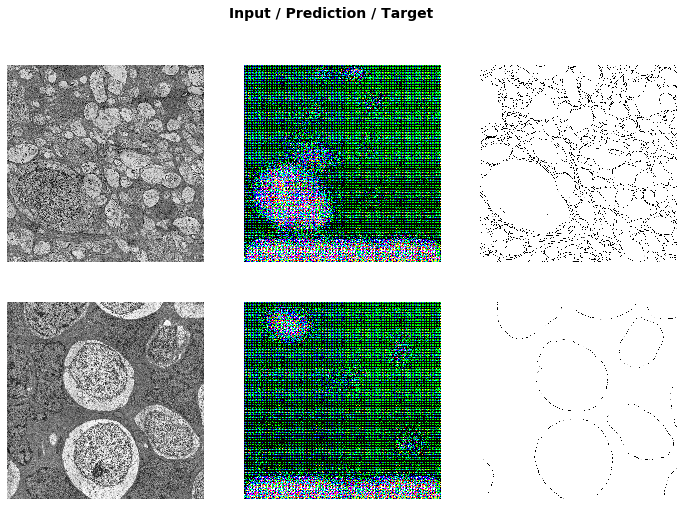

In [36]:
learn.show_results()

产生了彩色是为什么呢？  
和之前的对比看出：  
之前是仅仅对RGB三元组进行融合。  
这里也对像素进行了融合，因此

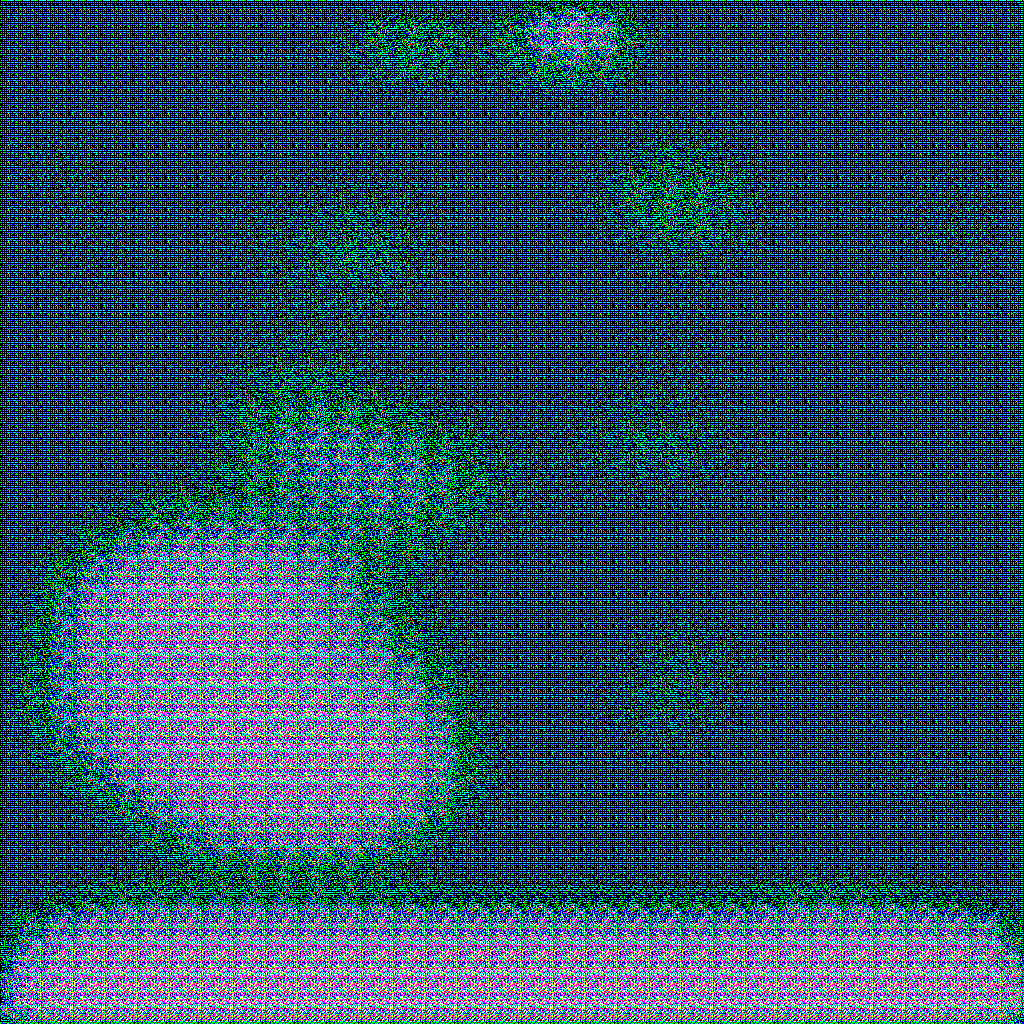

In [37]:
Image(learn.pred_batch(DatasetType.Valid).round()[0])

好吧，对于像素的扩充（32*32 -> 64 * 64）最后会导致模型表现性能变差

# 尝试使用resnet

In [38]:
def simple_cnn(actns:Collection[int], kernel_szs:Collection[int]=None,
               strides:Collection[int]=None, bn=False) -> nn.Sequential:
    "CNN with `conv_layer` defined by `actns`, `kernel_szs` and `strides`, plus batchnorm if `bn`."
    nl = len(actns)-1
    kernel_szs = ifnone(kernel_szs, [3]*nl)
    strides    = ifnone(strides   , [1]*nl)
    layers = [conv_layer(actns[i], actns[i+1], kernel_szs[i], stride=strides[i], padding = 1,
              norm_type=(NormType.Batch if bn and i<(len(strides)-1) else None)) for i in range_of(strides)]
    return nn.Sequential(*layers)

In [39]:
class Mymodel(torch.nn.Module):
    def __init__(self, basic_model):
        super().__init__()
        self.basic_model = torch.nn.ModuleList(basic_model.children())
        
    def forward(self, x):
        for layer in self.basic_model.children():
            x = x + layer(x)
        x = F.sigmoid(x)
        return x

In [40]:
model = Mymodel(simple_cnn([3, 3, 3, 3, 3], bn = True))

In [41]:
learn = Learner(data, model, loss_func = F.binary_cross_entropy, metrics = modified_metric)

In [42]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,modified_metric,time
0,0.755293,0.570118,0.138976,00:26
1,0.723072,0.601907,0.128461,00:28
2,0.687836,0.575369,0.114881,00:30
3,0.650615,0.523818,0.111646,00:29
4,0.612633,0.473219,0.113191,00:30
5,0.576893,0.439596,0.112155,00:21
6,0.545284,0.417244,0.109739,00:28
7,0.518391,0.402514,0.107713,00:27
8,0.495807,0.397773,0.106780,00:37
9,0.477578,0.397344,0.106189,00:24


/home/liangjiaxi/anaconda3/envs/tensorflow2/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [43]:
learn.save('./stage2')

In [44]:
learn = None
gc.collect()

25553

In [7]:
class MyModel(torch.nn.Module):
    def __init__(self, basic_model):
        super().__init__()
        self.basic_model = basic_model
        
    def forward(self, x):
        for layer in self.basic_model.children():
            x = x + layer(x)
        x = F.sigmoid(x)  # return logits
        return x

In [8]:
def simple_cnn(actns:Collection[int], kernel_szs:Collection[int]=None,
               strides:Collection[int]=None, bn=False) -> nn.Sequential:
    "CNN with `conv_layer` defined by `actns`, `kernel_szs` and `strides`, plus batchnorm if `bn`."
    nl = len(actns)-1
    kernel_szs = ifnone(kernel_szs, [3]*nl)
    strides    = ifnone(strides   , [1]*nl)
    layers = [nn.Sequential(
        conv_layer(actns[i], 128, kernel_szs[i], stride=strides[i], padding = 1,
              norm_type=(NormType.Batch if bn and i<(len(strides)-1) else None)),
        conv_layer(128, actns[i+1], kernel_szs[i], stride=strides[i], padding = 1,
              norm_type=(NormType.Batch if bn and i<(len(strides)-1) else None))
                            ) for i in range_of(strides)]
    
    return nn.Sequential(*layers)
model = MyModel(simple_cnn([3, 3, 3, 3, 3], bn = True))
def my_loss(x,y):
    x = x.view(-1)
    y = y.view(-1)
    loss = F.binary_cross_entropy(x, y, reduction= 'none')
    weight = torch.ones_like(loss)
    zeros = 1.0 / torch.sqrt((y == 0).sum().float() + 1e-14)
    ones = 1.0 / torch.sqrt((y == 1).sum().float() + 1e-14)
    weight[y == 0]  = zeros.item()
    weight[y == 1] = ones.item()
    loss = loss * weight
    loss = loss.mean()
    return loss

def my_modified_metric(x, y):
    x = x.view(-1)
    y = y.view(-1)
    assert x.shape == y.shape
    x = x.round()
    y = y.long()
    assert x.shape == y.shape

    return torch.tensor(f1_score(y, x, pos_label = 0)) # 修改pos的标签是啥

learn = Learner(data, model, loss_func = my_loss, metrics = my_modified_metric)

In [63]:
learn.summary()

/home/liangjiaxi/anaconda3/envs/tensorflow2/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


MyModel
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 1024, 1024]    3,456      True      
______________________________________________________________________
ReLU                 [128, 1024, 1024]    0          False     
______________________________________________________________________
BatchNorm2d          [128, 1024, 1024]    256        True      
______________________________________________________________________
Conv2d               [3, 1024, 1024]      3,456      True      
______________________________________________________________________
ReLU                 [3, 1024, 1024]      0          False     
______________________________________________________________________
BatchNorm2d          [3, 1024, 1024]      6          True      
______________________________________________________________________
Conv2d               [128, 1024, 1024]    3,456      True      
______________________________________________________

In [64]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


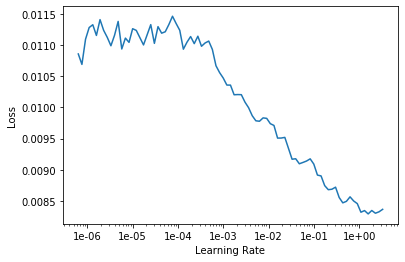

In [65]:
learn.recorder.plot()

In [66]:
learn.fit_one_cycle(30, max_lr= 1 ) # 为什么lr可以取这么大？因为我们对loss进行了加权，导致实际的学习率会很小

epoch,train_loss,valid_loss,my_modified_metric,time
0,0.009360,0.047865,0.070530,00:18
1,0.008281,0.010228,0.140554,00:18
2,0.007949,0.008596,0.097664,00:29
3,0.007836,0.007883,0.049390,00:21
4,0.007659,0.007251,0.147686,00:19
5,0.007527,0.007273,0.137709,00:25
6,0.007433,0.007270,0.119023,00:26
7,0.007361,0.007146,0.137104,00:21
8,0.007301,0.007148,0.146168,00:25
9,0.007385,0.007649,0.151358,00:28


In [67]:
learn.save('stage3')

/home/liangjiaxi/anaconda3/envs/tensorflow2/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


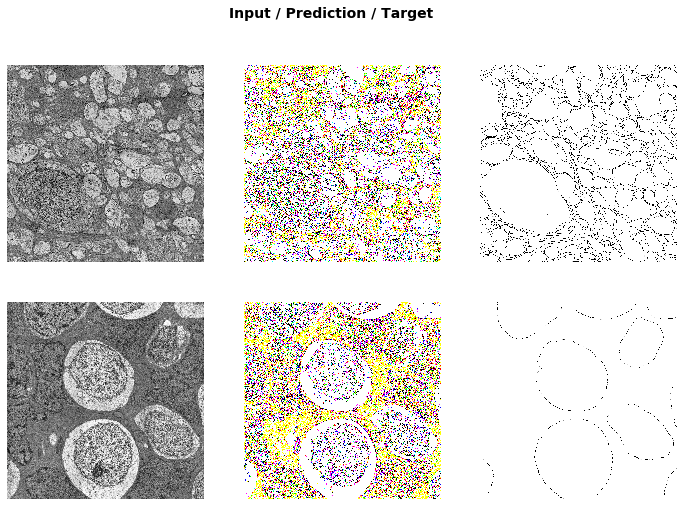

In [68]:
learn.show_results()

然后我突然想起了一个神器，unet?

In [9]:
learn = None
gc.collect()

0

In [11]:
def my_loss(x,y):
    device = x.device
    x = x.view(-1)
    y = y.view(-1)

    loss = F.binary_cross_entropy_with_logits(x, y, reduction= 'none')
    weight = torch.ones_like(loss)
    zeros = 1.0 / (torch.sqrt((y == 0).sum().float()) + 1e-14)
    ones = 1.0 / (torch.sqrt((y == 1).sum().float()) + 1e-14)

    weight[y == 0]  = zeros.item()
    weight[y == 1] = ones.item()
    
    loss = loss * weight
    loss = loss.mean()
    return loss

def my_modified_metric(x, y):
    x = x.view(-1)
    y = y.view(-1)
    assert x.shape == y.shape
    x = F.sigmoid(x)
    x = x.round()
    y = y.long()
    assert x.shape == y.shape

    return torch.tensor(f1_score(y, x, pos_label = 0)) # 修改pos的标签是啥

In [12]:
learn = unet_learner(data, models.resnet18, metrics = my_modified_metric, wd = 1e-2, loss_func = my_loss)

In [13]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 512, 512]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 512, 512]       128        True      
______________________________________________________________________
ReLU                 [64, 512, 512]       0          False     
______________________________________________________________________
MaxPool2d            [64, 256, 256]       0          False     
______________________________________________________________________
Conv2d               [64, 256, 256]       36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 256, 256]       128        True      
______________________________________________________________________
ReLU                 [64, 256, 256]       0          False     
__________________________________________________

In [15]:
learn.fit(10)

epoch,train_loss,valid_loss,my_modified_metric,time
0,0.007158,0.006729,0.156498,00:19
1,0.007257,0.006723,0.155096,00:19
2,0.007406,0.006719,0.156570,00:18
3,0.007306,0.006712,0.175317,00:20
4,0.007274,0.006706,0.180606,00:19
5,0.007331,0.006702,0.176248,00:19
6,0.007303,0.006697,0.189394,00:21
7,0.007289,0.006694,0.187398,00:27
8,0.007334,0.006711,0.186611,00:37
9,0.007374,0.006698,0.142713,00:40


In [16]:
learn.save('proteins_unet')

In [17]:
learn.unfreeze()

In [22]:
learn.fit_one_cycle(10,max_lr=1e-1)

epoch,train_loss,valid_loss,my_modified_metric,time
0,0.007617,0.006723,0.157507,06:12
1,0.007374,0.006723,0.164920,00:20
2,0.007320,0.006729,0.166021,00:21
3,0.007221,0.006726,0.169382,00:20
4,0.007308,0.006725,0.167512,00:19
5,0.007381,0.006724,0.167981,00:19
6,0.007413,0.006723,0.164255,00:18
7,0.007368,0.006723,0.166242,00:19
8,0.007420,0.006723,0.160677,00:20
9,0.007378,0.006723,0.159849,00:21


/home/liangjiaxi/anaconda3/envs/tensorflow2/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


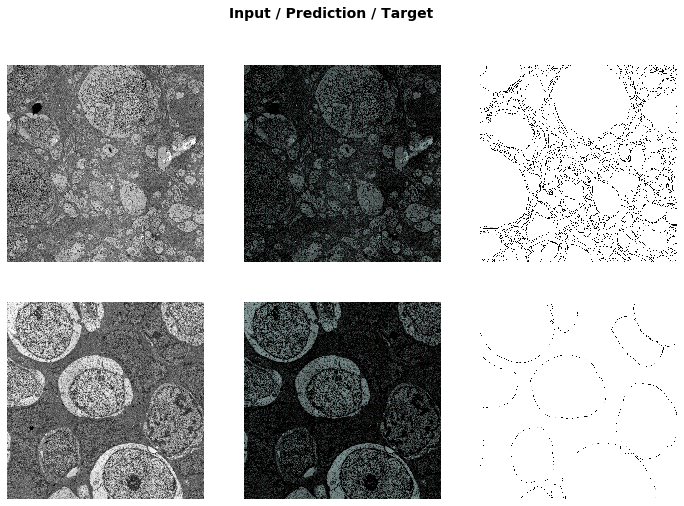

In [21]:
learn.show_results()

In [23]:
learn.save('stage-4')

In [29]:
learn = None
gc.collect()

27